# Import liberaries

In [1]:
import importlib
import header
importlib.reload(header)
from header import *

# Loading dataset

In [2]:
data = pd.read_csv("./datasets/ISCX_Botnet.csv") #every wine varibale is a isntance of pandas
data = data.loc[:, ~data.columns.str.contains('^Unnamed')] # Removing of 'Umnamed' column
data = pd.DataFrame(data) #converting it to Pandas DataFrame

In [3]:
# print("Total count of values is: ",data['Label'].count())
print('Initial shape of ISCX dataset: ', data.shape)
print('\nWeightage of benign and malicious data.')
print(data['Label'].value_counts())

Initial shape of ISCX dataset:  (170461, 61)

Weightage of benign and malicious data.
0    127745
1     42716
Name: Label, dtype: int64


# Balancing of data label classes

# Selection of Benign indexes and saving of benign data to a file


In [4]:
np.random.seed(0)
remove_row = 70000 # number of rows to be removed

zero_label_df = pd.DataFrame(data.query('Label == 0')) # dataframe to store benigns
zero_label_df.to_csv('./datasets/only_benign.csv', index = False)

# Random regenration of indexes
indexes = np.random.choice(zero_label_df.index, remove_row, replace=False) 
# droping random 70000 benigns fom dataframe
df_after_drop = zero_label_df.drop(indexes)
print(df_after_drop['Label'].value_counts())

0    57745
Name: Label, dtype: int64


# Selection of bots indexes and data transformation

In [5]:
one_label_df = pd.DataFrame(data[data['Label'] != 0]) # selecting 'Label = 1' from data
one_label_df.to_csv('./datasets/only_bots.csv', index=False)# Saving to .csv
dataframes = [df_after_drop, one_label_df] # Puttings both frames in a list
concat_df = pd.concat(dataframes) # concatenation of frames
concat_df.to_csv('./datasets/ISCX_Botnet(Prep).csv', index = False) # Saving to .csv

# Loading preprocessed file

In [6]:
prep_df = pd.read_csv("./datasets/ISCX_Botnet(Prep).csv") # load preprocessed file to data 
print('Final shape of ISCX dataset: ', prep_df.shape)
print('\nNew Weightage of benign and malicious data.')
print(prep_df['Label'].value_counts())

Final shape of ISCX dataset:  (100461, 61)

New Weightage of benign and malicious data.
0    57745
1    42716
Name: Label, dtype: int64


#  Generating synthetic data using GANs

In [18]:
# GAN class
from keras.utils.vis_utils import plot_model
class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))
        
        # prepare lists for storing stats each iteration
        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # record history
            d1_hist.append(d_loss_real[0])
            d2_hist.append(d_loss_fake[0])
            g_hist.append(g_loss)
            a1_hist.append(d_loss_real[1])
            a2_hist.append(d_loss_fake[1])
            
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                
        plt.subplot(2, 1, 1)
        plt.plot(d1_hist, label='d-real')
        plt.plot(d2_hist, label='d-fake')
        plt.plot(g_hist, label='gen')
        plt.legend()
        # plot discriminator accuracy
        plt.subplot(2, 1, 2)
        plt.plot(a1_hist, label='acc-real')
        plt.plot(a2_hist, label='acc-fake')
        plt.legend()
        # save plot to file
        plt.savefig('plot_line_plot_loss.png')
        plt.close()
                

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [27]:
# dataset loading
df = pd.read_csv('./datasets/only_bots.csv')
data_cols = df.columns

# initialise training parameters
#batch size of 32 and train it for 301 epochs
noise_dim = 32
dim = 128
batch_size = 32

log_step = 50
epochs = 150+1
learning_rate = 5e-4
models_dir = 'model'

df[data_cols] = df[data_cols]

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

In [28]:
# making of directory
!mkdir model

In [29]:
# start training of GAN's model
model = GAN
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

0 [D loss: 0.716877, acc.: 45.31%] [G loss: 0.653983]
1 [D loss: 0.668717, acc.: 50.00%] [G loss: 0.675265]
2 [D loss: 0.638195, acc.: 50.00%] [G loss: 0.695587]
3 [D loss: 0.618699, acc.: 50.00%] [G loss: 0.708598]
4 [D loss: 0.628852, acc.: 50.00%] [G loss: 0.684467]
5 [D loss: 0.661059, acc.: 50.00%] [G loss: 0.649385]
6 [D loss: 0.706270, acc.: 50.00%] [G loss: 0.638305]
7 [D loss: 0.729403, acc.: 50.00%] [G loss: 0.719510]
8 [D loss: 0.713009, acc.: 50.00%] [G loss: 0.916825]
9 [D loss: 0.702198, acc.: 48.44%] [G loss: 1.130523]
10 [D loss: 0.668824, acc.: 62.50%] [G loss: 1.258196]
11 [D loss: 0.692935, acc.: 45.31%] [G loss: 1.156194]
12 [D loss: 0.711686, acc.: 45.31%] [G loss: 1.035517]
13 [D loss: 0.701972, acc.: 50.00%] [G loss: 1.091927]
14 [D loss: 0.655748, acc.: 50.00%] [G loss: 1.079945]
15 [D loss: 0.630892, acc.: 56.25%] [G loss: 1.044944]
16 [D loss: 0.630067, acc.: 68.75%] [G loss: 1.030273]
17 [D loss: 0.637095, acc.: 82.81%] [G loss: 0.900586]
18 [D loss: 0.651356

150 [D loss: 0.581036, acc.: 64.06%] [G loss: 1.123159]


In [30]:
# making other directories inside model's directory
%cd model
!mkdir gan
%cd gan
!mkdir saved

C:\Users\shan-\Desktop\Evasion\model
C:\Users\shan-\Desktop\Evasion\model\gan


In [31]:
%cd C:\Users\shan-\Desktop\Evasion

C:\Users\shan-\Desktop\Evasion


In [32]:
# Saving trained generator 
synthesizer.save('model/gan/saved', 'generator_bots')

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense_16 (Dense)             (32, 128)                 4224      
_________________________________________________________________
dense_17 (Dense)             (32, 256)                 33024     
_________________________________________________________________
dense_18 (Dense)             (32, 512)                 131584    
_________________________________________________________________
dense_19 (Dense)             (32, 61)                  31293     
Total params: 200,125
Trainable params: 200,125
Non-trainable params: 0
_________________________________________________________________


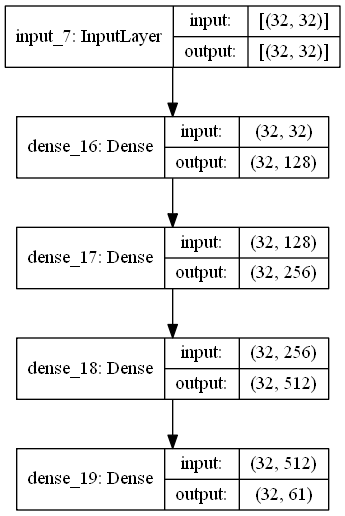

In [33]:
# from keras.utils.vis_utils import plot_model
# Model summary of generator
synthesizer.generator.summary()
plot_model(synthesizer.generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 61)]                0         
_________________________________________________________________
dense_20 (Dense)             (32, 512)                 31744     
_________________________________________________________________
dropout_4 (Dropout)          (32, 512)                 0         
_________________________________________________________________
dense_21 (Dense)             (32, 256)                 131328    
_________________________________________________________________
dropout_5 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_22 (Dense)             (32, 128)                 32896     
_________________________________________________________________
dense_23 (Dense)             (32, 1)                 

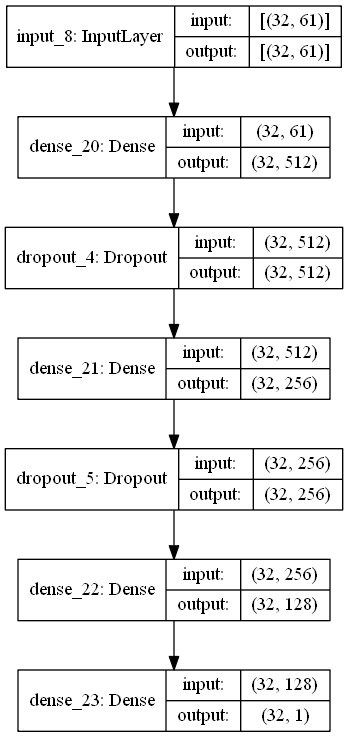

In [34]:
# Model summary of discriminator
synthesizer.discriminator.summary()
plot_model(synthesizer.discriminator, to_file='discrimina_plot.png', show_shapes=True, show_layer_names=True)

# Evaluation of generated data

In [35]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

No handles with labels found to put in legend.


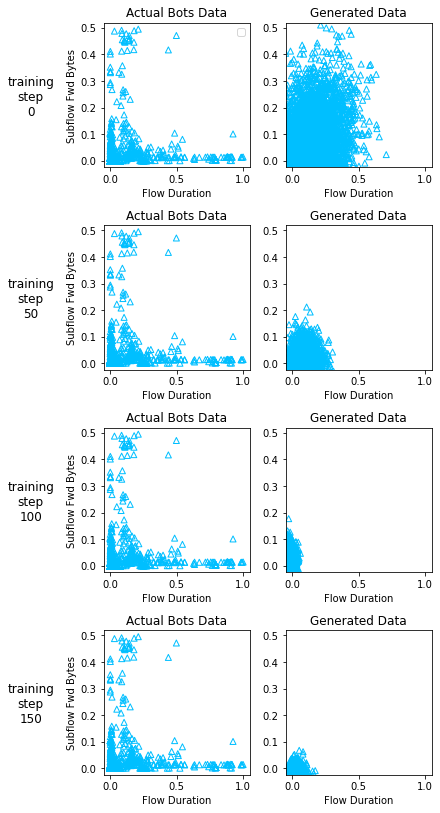

In [36]:
# Setup parameters visualization parameters
seed = 17
test_size = 5000 # number of bots
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['^','o']

col1, col2 = 'Flow Duration', 'Subflow Fwd Bytes'

base_dir = 'model/'

#Actual bots data visualisation
model_steps = [ 0, 50, 100, 150]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('Label'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Bots Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputsssss.png')

In [32]:
print(gen_samples.shape)
gen_samples = gen_samples.loc[:, ~gen_samples.columns.str.contains('^Unnamed')]
print(df.shape, gen_samples.shape)

(5000, 61)
(42716, 61) (5000, 61)


In [33]:
# normalizing GAN generated Labels from real number values to 0 or 1 
label = gen_samples['Label']
label[label < 0] = 0
label[label > 1] = 1
label = np.round(label)
rem_float = [math.floor(float(i)) for i in label]
gen_samples['Label'] = rem_float
print(gen_samples['Label'].value_counts())
# gen_samples.to_csv('./datasets/new_gan_bots.csv')

1    5000
Name: Label, dtype: int64


No handles with labels found to put in legend.


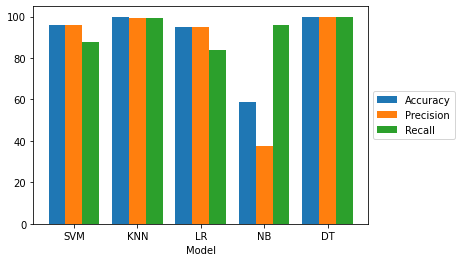

In [34]:
# %matplotlib inline
X = ['SVM','KNN','LR','NB', 'DT']
Y = [95.89, 99.61, 94.89, 58.72 , 99.91]
Z = [95.69, 99.30, 94.96, 37.30 , 99.85]
A = [87.49, 99.13, 83.98, 96.15 , 99.81]

def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)
    plt.xlabel('Model')
    plt.legend(loc="upper left")
    plt.gca().legend(('Accuracy','Precision', 'Recall'), loc='center left', bbox_to_anchor=(1, 0.5))
    
subcategorybar(X, [Y,Z,A])
plt.show()